# RESEAUX RECURENTS


Les réseaux de neurones récurrents (ou RNN pour Recurrent Neural Networks) sont une catégorie de réseaux de neurones dédiée au traitement de séquences

<img src='images/rnn1.png'>


<img src='images/rnn2.jpg'>

1 - Classification d'image
2 - Description d'images.
3 - Analyse des sentiments.
4 - Traduction
5 - Classification de vidéos

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import re
import string

In [4]:
df = pd.read_csv("datasets/twitter.csv")

In [5]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
## Répartition du dataset
print((df.target == 1).sum()) # Catastrophe
print((df.target == 0).sum()) # Non

3271
4342


## PREPROCESSING

### LES STOPWORDS ET LES CARACTERES INUTILES

En NLP les stopword sont des mots n'ajoutant aucun sens particulier a une phrase. En français on parle de mot vide ( de sens ). Il convient donc de les supprimer

In [7]:
# SI NLTK n'est pas installé pip install NLK
import nltk
# On télécharge les stopwords
nltk.download('stopwords')
# On importe les stopwords
from nltk.corpus import stopwords
# Les données étant en anglais on définit le lanqage des stopwords à utiliser
stop = set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\curun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


En plus de ces mots vides, il existe bon nombre de caractère inutiles pour le NLP comme la ponctuation ou les url ... On va donc créer des fonctions nous permettant de nettoyer nos données.

In [8]:
#Fonction supprimant les stopwords
def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

# Fonction de suppression des url
def text_cleaning(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text)     # Supp @
  text = re.sub(r'@[A-Za-zA-Z0-9]+', '', text)  # Supp @
  text = re.sub(r'@[A-Za-z]+', '', text)        # Supp @
  text = re.sub(r'@[-)]+', '', text)            # Supp @
  text = re.sub(r'#', '', text )                # Supp #
  text = re.sub(r'RT[\s]+', '', text)           # Supp RT
  text = re.sub(r'https?\/\/\S+', '', text)     # Supp Lien
  text = re.sub(r'&[a-z;]+', '', text)          # Supp '&gt;'

  return text

# Fonction de suppression la ponctuation
def remove_punct(text):
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)

In [9]:
# On supprime les stopwords
df["text"] = df.text.map(remove_stopwords)
# On supprime les URL de nos données
df["text"] = df.text.map(text_cleaning) 
# On supprime la ponctuation
df["text"] = df.text.map(remove_punct)

In [10]:
# Les données néttoyées
df.text

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       13000 people receive wildfires evacuation orde...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ahrary  control wild fires california even nor...
7610    m194 0104 utc5km volcano hawaii httptcozdtoyd8ebj
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

In [11]:
from collections import Counter
# Fonction retournant le nombre de mot unique
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count
counter = counter_word(df.text)

In [12]:
# On stocke le nombre de mot unique on s'en servira plus tard
num_unique_words = len(counter)

### SEPARATION DU DATASET

In [13]:
# On sépare notre dataset en jeu d'entairenement et de validation
from sklearn.model_selection import train_test_split

train_df,val_df = train_test_split(df,test_size=0.2)


# On sépare les données de la cible et on créé des tableaux pour stocker tout ça

train_phrases = train_df.text.to_numpy()
train_labels = train_df.target.to_numpy()
val_phrases = val_df.text.to_numpy()
val_labels = val_df.target.to_numpy()


### TOKENIZATION

Une machine ça ne comprend pas le texte, une machine ça traite des nombres, des chiffres, des vecteurs ...
Dans cette partie on va donc transformer notre texte pour qu'une machine le comprenne.
Lecture sur le sujet :
https://medium.com/@canerkilinc/hands-on-tensorflow-tokenizer-for-nlp-392c97d5874d

In [14]:
# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

# On transforme nos mots en vecteurs d'entier
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_phrases) 


In [15]:
# On transforme nos phrases en séquences d'entier
train_sequences = tokenizer.texts_to_sequences(train_phrases)
val_sequences = tokenizer.texts_to_sequences(val_phrases)


In [16]:
print(train_phrases[1])
print(train_sequences[1])


tracy blight thank following me
[5695, 558, 457, 841, 154]


### PAD

Les séquences ( phrases ) que nous passerons aux modèles doivent avoir la même longeur, le même nombre de mot. Dans le cas qui nous intéresse il est évident que des tweets n'ont pas forcément le même nombre de mot il va donc falloir ajuster chaque séquence en conséquence.
Lecture sur le sujet :
https://medium.com/@canerkilinc/padding-for-nlp-7dd8598c916a

In [17]:
# On importe de tensorFlow
from tensorflow.keras.preprocessing.sequence import pad_sequences
# On définit la longueur max de chaque séquence.
max_length = 20
# On "pad" nos phrases
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")

val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")

In [18]:
# Vérification
print(train_phrases[1])
print(train_sequences[1])
print(train_padded[1])

tracy blight thank following me
[5695, 558, 457, 841, 154]
[5695  558  457  841  154    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


In [19]:
# Fonction de decryptage
def decode(sequence):
    return " ".join([word_index.get(idx, "?") for idx in sequence])

In [20]:
word_index = tokenizer.word_index
word_index = reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])
decoded_text = decode(train_sequences[1])

print(train_sequences[1])
print(decoded_text)



[5695, 558, 457, 841, 154]
tracy blight thank following me


## CREATION DU MODELE

In [21]:
from tensorflow.keras import layers

In [26]:
model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length))

model.add(layers.LSTM(64, dropout=0.5))

model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 32)            659872    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 684,769
Trainable params: 684,769
Non-trainable params: 0
_________________________________________________________________


In [27]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [28]:
r = model.fit(train_padded, train_labels, epochs=20, validation_data=(val_padded, val_labels), verbose=2)

Train on 6090 samples, validate on 1523 samples
Epoch 1/20
6090/6090 - 4s - loss: 0.5650 - accuracy: 0.6923 - val_loss: 0.4762 - val_accuracy: 0.7787
Epoch 2/20
6090/6090 - 2s - loss: 0.3339 - accuracy: 0.8634 - val_loss: 0.4717 - val_accuracy: 0.7905
Epoch 3/20
6090/6090 - 2s - loss: 0.2073 - accuracy: 0.9238 - val_loss: 0.5890 - val_accuracy: 0.7715
Epoch 4/20
6090/6090 - 2s - loss: 0.1362 - accuracy: 0.9522 - val_loss: 0.6626 - val_accuracy: 0.7617
Epoch 5/20
6090/6090 - 2s - loss: 0.0956 - accuracy: 0.9667 - val_loss: 0.7414 - val_accuracy: 0.7695
Epoch 6/20
6090/6090 - 2s - loss: 0.0735 - accuracy: 0.9741 - val_loss: 0.7297 - val_accuracy: 0.7623
Epoch 7/20
6090/6090 - 2s - loss: 0.0611 - accuracy: 0.9800 - val_loss: 1.0263 - val_accuracy: 0.7617
Epoch 8/20
6090/6090 - 2s - loss: 0.0516 - accuracy: 0.9834 - val_loss: 0.7816 - val_accuracy: 0.7656
Epoch 9/20
6090/6090 - 2s - loss: 0.0483 - accuracy: 0.9857 - val_loss: 0.7871 - val_accuracy: 0.7577
Epoch 10/20
6090/6090 - 2s - loss:

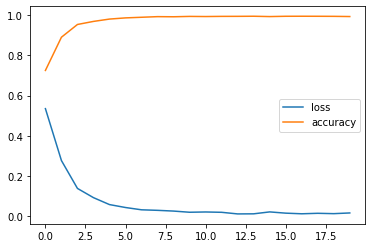

In [23]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['accuracy'], label= 'accuracy')
plt.legend()

In [24]:
predictions = model.predict(train_padded)
predictions = [1 if p > 0.5 else 0 for p in predictions]

In [25]:
print(train_phrases[10:20])

print(train_labels[10:20])
print(predictions[15].round())

['every time really good day someone ruin'
 'bagans sabrina dad rescued dude kept cage weve since 4 httptco1k2phqcuw8'
 ' please sign share petition save wild horses arizona httptco3tssxphufe '
 ' game officially collapsed'
 'usgs eq 06  8km ssw anza california time20150806 012624 utc20150805 182624 070 httptco3bwwnlsxhb earthquake'
 'former township fire truck used philippines  langley times httptcoimilsfxntf filipino'
 'sustainability task force presents levy fund emergency services  wdtv httptco2fibe2haxc'
 'could billboards hot 100 chart displaced socialmediadriven music charts httptcowvlah8jrxe'
 'reddits new content policy goes effect many horrible subreddits banned quarantined httptcom4tczaawpt'
 'kill got court day earl']
[0 1 0 0 1 0 1 1 0 0]


AttributeError: 'int' object has no attribute 'round'

In [ ]:
def predict_catastrophe(text):
  # preprocessing the given text 
  text = text_cleaning(text[0])
  text = remove_punct(text)
  text = remove_stopwords(text)
  
  text_seq = tokenizer.texts_to_sequences(text)
  text_pad = pad_sequences(text_seq, maxlen=20)
  print(text_pad)
  # predicting the class
  predicted_sentiment = model.predict(text_pad)
  print(predicted_sentiment[0].round())
 



In [ ]:
predict_catastrophe(["big accident on road 71 !!! ???? "])